# Notebook objective

Create meaningful segments based on notification patterns over time. Meaningful is considered a user who opens a message.

Source: https://drive.google.com/drive/folders/1akT7jbXYy2-zLHEtnK3q6vqcQ-JdRO9H

# Rationale

I have selected the first exercise, user segment creation, because of the following reasons:
-	Most work a data scientist does is data cleaning, which includes customer segmentation. Because of that I thought it would be most useful to demonstrate my skills in this area;
-	Creating user segments is useful for any company and always adds value. Better understanding a client base allows for better user targeting and product improvement. On top of that, depending on the use case, segments can be stored in a feature storage to use for future product features and data analytics exercises;
-	I have worked on quite some message effectiveness/improvement campaigns and found that AB testing is the most reliable method to do this because it eliminates external influences (eg phone user broke, technical issues. Within the tech space Whereismytransport is in, it should be fairly easy to implement and manage this;
-	I would assume that geographical entities are already available for Whereismytransport, so creating a tool which extracts these wouldn't directly be of use.


# Potential next steps

- Add column message sending time - Users are likely to read a message when its useful for them (eg before rush hour);
- Depending on the use case of this excersis, outliers may be removed;
- Add more system features which are not available in the current dataset (eg reason for messaging, geographical area, transportation type, subscription type).

# Preparation

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Create a function which can create a histogram, split by a variable
def plot_histogram_dv(x, y):
    plt.hist(list(x[y == 0]), alpha=0.5, label='DV=0')
    plt.hist(list(x[y == 1]), alpha=0.5, label='DV=1')
    plt.title("Histogram of '{var_name}' per " + segment + " category".format(var_name=x.name))
    plt.xlabel("Value")
    plt.xticks(rotation='vertical')
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.show()

5:80: E501 line too long (95 > 79 characters)


## Folder structure

In [4]:
# Make root folder the current working directory
os.chdir('..')

In [5]:
input_folder = './data/raw/'

In [6]:
output_folder = './reports/figures/'

## Data import

In [7]:
alerts_df = pd.read_csv(input_folder + 'alerts.csv')
alerts_df.head(2)

,Unnamed: 0,document_id,published_at,description
0,0,-MUH7_dRaJMkhnxY9bHs,2021-02-24 03:58:39+00:00,🔥 Considera retrasos por servicios de emergenc...
1,1,-MUH7_dRaJMkhnxY9bHs,2021-02-24 03:58:39+00:00,🔥 Considera retrasos por servicios de emergenc...


In [8]:
dateparse = lambda x: datetime.strptime(x, '%Y%m%d')
notifications_df = pd.read_csv(input_folder + 'notfications.csv',
                               parse_dates=['event_date'])
notifications_df.head(2)

,Unnamed: 0,event_date,event_timestamp,event_name,user_id,join_key_value
0,0,2021-05-29,1622251203899000,notification_receive,283a1,-Maph6wn8GA3SjPIc9HA
1,1,2021-05-29,1622257988561000,notification_receive,283a1,-Maq63vqDUxQRawQ_3Au


1:1: E731 do not assign a lambda expression, use a def


In [9]:
notifications_df.isnull().sum().sum()

484

# Data cleaning

In [10]:
# Make date field a pandas date type
alerts_df['published_at'] = alerts_df['published_at'].str[:19]
alerts_df['published_at'] = pd.to_datetime(alerts_df['published_at'])
alerts_df['published_at']

0       2021-02-24 03:58:39
1       2021-02-24 03:58:39
2       2021-03-31 22:54:19
3       2021-03-31 22:54:19
4       2021-03-31 22:54:19
                ...        
13537   2021-04-30 21:32:24
13538   2021-05-04 00:52:21
13539   2021-03-26 14:44:15
13540   2021-01-27 17:51:51
13541   2021-06-25 11:25:49
Name: published_at, Length: 13542, dtype: datetime64[ns]

In [11]:
# Drop rows with missing date field
alerts_df.dropna(axis=0, inplace=True)
alerts_df[alerts_df['published_at'].isnull()]

,Unnamed: 0,document_id,published_at,description


In [12]:
# Recode similar event names
notifications_df['event_name'].replace('notification_received',
                                       'notification_receive', inplace=True)
notifications_df['event_name'].replace('notification_opened',
                                       'notification_open', inplace=True)

# Segment creation

This part of the notebook will be used to create meaningful segments. Meaningful is defined as a user opening a message, so each feature will be evaluated as such.

Note that outliers haven't been dealt with in this excersise. However, depending on the use case it may be useful to do something with them in order not to skew the results.

## active_days

In [13]:
segment = 'active_days'

In [14]:
# add columns first and last interaction
user_df = notifications_df.groupby('user_id')['event_date'].agg([np.min, np.max])
user_df.reset_index(inplace=True)
# create a new feature based active customer days
user_df[segment] = user_df['amax'] - user_df['amin']
user_df[segment] = user_df[segment].astype('timedelta64[D]') 

2:80: E501 line too long (81 > 79 characters)


In [15]:
user_df[segment].describe()

count    18258.000000
mean        37.334045
std         51.458901
min          0.000000
25%          0.000000
50%         11.000000
75%         57.000000
max        188.000000
Name: active_days, dtype: float64

<AxesSubplot:>

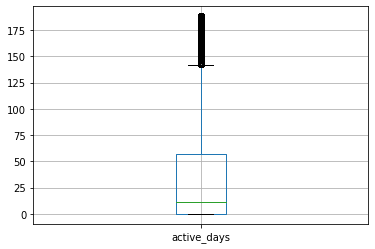

In [16]:
user_df.boxplot(segment)

This boxplot shows that there are some outliers in the dataset, which can skew the results.

## message_opened_count

In [17]:
segment = 'message_opened_count'

In [18]:
# add outcome features interactions
opened_df = notifications_df[notifications_df['event_name'] == 'notification_open']
opened_df = opened_df[['user_id', 'event_name']].groupby('user_id').count().reset_index()
user_df = pd.merge(user_df, opened_df, how='left', on='user_id')
user_df.rename(columns={'event_name': segment}, inplace=True)
user_df[segment].fillna(0, inplace=True)

2:80: E501 line too long (83 > 79 characters)
3:80: E501 line too long (89 > 79 characters)


In [19]:
user_df.head()

,user_id,amin,amax,active_days,message_opened_count
0,00070,2021-01-25,2021-01-25,0.0,0.0
1,00087,2021-01-08,2021-01-21,13.0,0.0
2,000b3,2021-05-08,2021-05-08,0.0,0.0
3,000e1,2021-03-17,2021-03-24,7.0,0.0
4,00117,2021-03-01,2021-03-01,0.0,0.0


In [20]:
user_df[segment].describe()

count    18258.000000
mean         2.193504
std          9.770521
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        637.000000
Name: message_opened_count, dtype: float64

<AxesSubplot:>

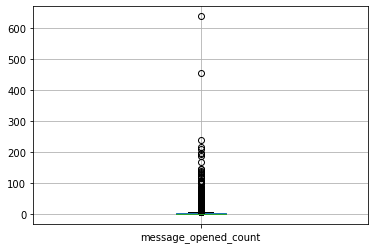

In [21]:
user_df.boxplot(segment)

This boxplot shows that there are some outliers in the dataset, which can skew the results.

## message_opened_TRUE

In [22]:
segment = 'message_opened_TRUE'

In [23]:
user_df[segment] = user_df['message_opened_count'] > 0
user_df[segment].value_counts(normalize=True)

False    0.588783
True     0.411217
Name: message_opened_TRUE, dtype: float64

<AxesSubplot:title={'center':'message_opened_TRUE'}>

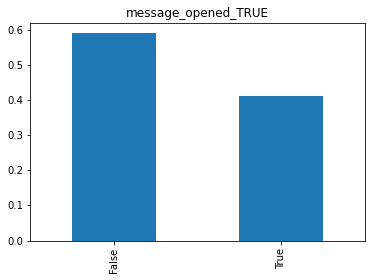

In [24]:
user_df[segment].value_counts(normalize=True).plot.bar(title=segment)

This segment shows that 41% of all users opened at least one message they received.

## message_received_count

In [25]:
segment = 'message_received_count'

In [26]:
# Create count of messages each customer received
received_df = notifications_df[notifications_df['event_name'] == 'notification_receive']
received_df = received_df[['user_id', 'event_name']].groupby('user_id').count().reset_index()
user_df = pd.merge(user_df, received_df, how='left', on='user_id')
user_df.rename(columns={'event_name': segment}, inplace=True)
user_df[segment].fillna(0, inplace=True)

2:80: E501 line too long (88 > 79 characters)
3:80: E501 line too long (93 > 79 characters)


<AxesSubplot:title={'center':'message_received_count'}, xlabel='message_opened_TRUE'>

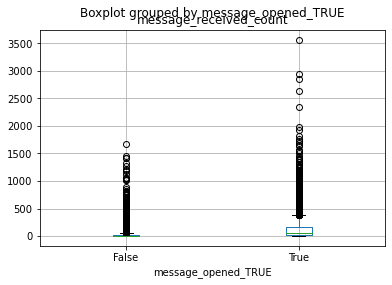

In [27]:
user_df.boxplot(segment, by='message_opened_TRUE')

This boxplot shows that customers who opened a message are more likely to have received more messages.

## Message opened rate

In [28]:
segment = 'message_opened_rate'

In [29]:
user_df[segment] = user_df['message_opened_count'] / user_df['message_received_count']
user_df[segment].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

1:80: E501 line too long (86 > 79 characters)


In [30]:
user_df[segment].describe()

count    18258.000000
mean         0.055794
std          0.148107
min          0.000000
25%          0.000000
50%          0.000000
75%          0.034483
max          2.000000
Name: message_opened_rate, dtype: float64

## Average messages per active day

In [31]:
segment = 'message_daily_avg'

In [32]:
user_df[segment] = user_df['message_received_count'] / user_df['active_days']
user_df[segment].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [33]:
user_df[segment].describe()

count    18258.000000
mean         1.902396
std          3.003240
min          0.000000
25%          0.000000
50%          1.035243
75%          2.581208
max        166.000000
Name: message_daily_avg, dtype: float64

<AxesSubplot:title={'center':'message_daily_avg'}, xlabel='message_opened_TRUE'>

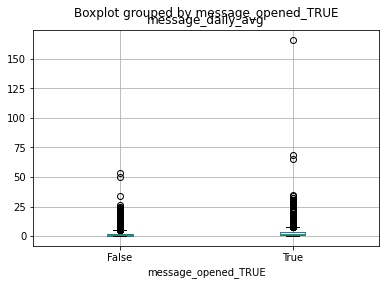

In [34]:
user_df.boxplot(segment, by='message_opened_TRUE')

## active user

**Active user** - Considering that it is unlikely that all users in the database are active users, it may be useful to filter out whether customers are active. For this analysis, we have assumed that a user who has received or interacted with a message in the past seven days, is considered an active user. This can be adjusted depending on the business requirements.

In [35]:
last_week = user_df['amax'].max() - timedelta(days=6)
user_df['active_user'] = user_df['amax'] > last_week
user_df['active_user'].value_counts(normalize=True)

False    0.804415
True     0.195585
Name: active_user, dtype: float64

Around 20% of users have been active in the last week of the dataset.

## Segment evaluation

In [36]:
user_df.corr()

,active_days,message_opened_count,message_opened_TRUE,message_received_count,message_opened_rate,message_daily_avg,active_user
active_days,1.000000,0.255833,0.395446,0.629823,-0.072463,0.015835,0.553033
message_opened_count,0.255833,1.000000,0.268643,0.294607,0.225241,0.113129,0.179559
message_opened_TRUE,0.395446,0.268643,1.000000,0.314324,0.450782,0.190322,0.275726
message_received_count,0.629823,0.294607,0.314324,1.000000,-0.082076,0.340406,0.408267
message_opened_rate,-0.072463,0.225241,0.450782,-0.082076,1.000000,-0.025403,-0.023383
message_daily_avg,0.015835,0.113129,0.190322,0.340406,-0.025403,1.000000,0.167935
active_user,0.553033,0.179559,0.275726,0.408267,-0.023383,0.167935,1.000000


<AxesSubplot:>

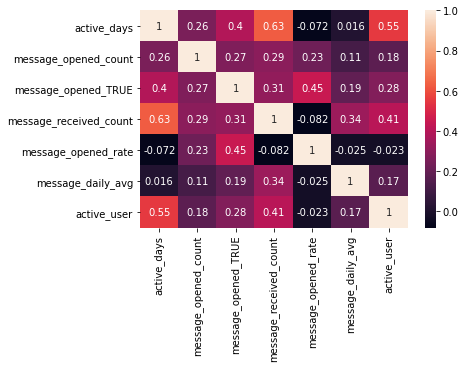

In [37]:
sns.heatmap(user_df.corr(), annot=True)

The above correlation table and graph shows that 'activity days' strongly correlated with 'message_received_count', which makes sense as people who are active longer will likely have received more messages.

# Clustering

Clustering is a form of unsupervised machine learning which can be used to segment large datasets into groups of users with distinct behaviour. Depending on the business case, users can be targeted based on their behaviour by, for instance, the marketing team.

## Data standarisation

In [38]:
# Drop unnecessary columns
standardised_df = user_df.drop(['user_id', 'amin', 'amax'], axis=1)

In [39]:
# Standardise dataset in preparation of clustering
scaler = MinMaxScaler()
scaler.fit(standardised_df)
scaled_features = scaler.transform(standardised_df)
columns = standardised_df.columns
standardised_df = pd.DataFrame(scaled_features, columns=columns)

In [40]:
standardised_df.describe()

,active_days,message_opened_count,message_opened_TRUE,message_received_count,message_opened_rate,message_daily_avg,active_user
count,18258.000000,18258.000000,18258.000000,18258.000000,18258.000000,18258.000000,18258.000000
mean,0.198585,0.003443,0.411217,0.020792,0.027897,0.011460,0.195585
std,0.273718,0.015338,0.492068,0.044829,0.074053,0.018092,0.396662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.001122,0.000000,0.000000,0.000000
50%,0.058511,0.000000,0.000000,0.004208,0.000000,0.006236,0.000000
75%,0.303191,0.003140,1.000000,0.019635,0.017241,0.015549,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
standardised_df.isnull().sum()

active_days               0
message_opened_count      0
message_opened_TRUE       0
message_received_count    0
message_opened_rate       0
message_daily_avg         0
active_user               0
dtype: int64

## Choose cluster count

The elbow method has been used to identify the ideal number of clusters.

In [42]:
sse = []

# Will take some time
for k in range(1, 15):
    km = KMeans(n_clusters=k)
    km.fit(standardised_df)
    sse.append(km.inertia_)

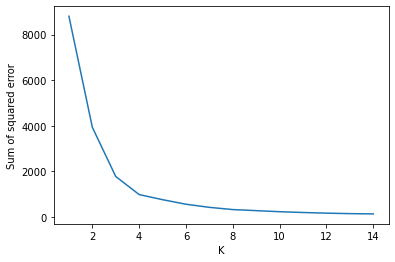

In [43]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(range(1, 15), sse)

When applying the elbow method, the above graph shows that 3 clusters is optimal.

## Clustering

In [44]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(standardised_df)
user_df['cluster'] = clusters
user_df.head()

,user_id,amin,amax,active_days,message_opened_count,message_opened_TRUE,message_received_count,message_opened_rate,message_daily_avg,active_user,cluster
0,00070,2021-01-25,2021-01-25,0.0,0.0,False,4.0,0.0,0.000000,False,0
1,00087,2021-01-08,2021-01-21,13.0,0.0,False,17.0,0.0,1.307692,False,0
2,000b3,2021-05-08,2021-05-08,0.0,0.0,False,1.0,0.0,0.000000,False,0
3,000e1,2021-03-17,2021-03-24,7.0,0.0,False,5.0,0.0,0.714286,False,0
4,00117,2021-03-01,2021-03-01,0.0,0.0,False,5.0,0.0,0.000000,False,0


In [45]:
user_df['cluster'].value_counts(normalize=True)

0    0.527440
1    0.276974
2    0.195585
Name: cluster, dtype: float64

In [46]:
cluster_df = pd.get_dummies(user_df['cluster'])

In [47]:
evaluators_df = user_df[['message_opened_TRUE', 'message_opened_rate']]

In [48]:
cluster_df = cluster_df.merge(evaluators_df,
                              how='outer',
                              left_index=True,
                              right_index=True)

## Clustering evaluation

In [49]:
cluster_df.corr()

,0,1,2,message_opened_TRUE,message_opened_rate
0,1.000000,-0.653885,-0.520938,-0.882909,-0.397999
1,-0.653885,1.000000,-0.305191,0.740602,0.464744
2,-0.520938,-0.305191,1.000000,0.275726,-0.023383
message_opened_TRUE,-0.882909,0.740602,0.275726,1.000000,0.450782
message_opened_rate,-0.397999,0.464744,-0.023383,0.450782,1.000000


<AxesSubplot:>

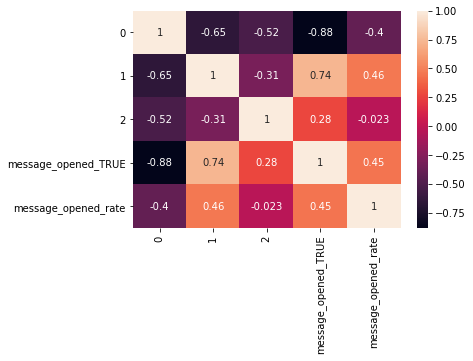

In [50]:
sns.heatmap(cluster_df.corr(), annot=True)

In [51]:
user_df['cluster'].value_counts(normalize=True)

0    0.527440
1    0.276974
2    0.195585
Name: cluster, dtype: float64

Using the clustering exercise, the user data has been sliced into 3 groups, ranging from in between 20% and 53% of the users. Each cluster has significant different correlation with the target variable:
- Cluster 1: likely to open messages once received
- Cluster 0: unlikely to open messages once received
- Cluster 2: somewhat more likely to open a message once received

A next step is to make these clusters actionable, by adding user patterns per cluster. These can then be used by e.g. a marketing team as persona to target customer segments.

In [55]:
cluster0_df = user_df[user_df['cluster'] == 1]
cluster0_df.describe()

,active_days,message_opened_count,message_received_count,message_opened_rate,message_daily_avg,cluster
count,5057.000000,5057.000000,5057.000000,5057.000000,5057.000000,5057.0
mean,40.614198,3.858216,79.971327,0.167001,2.289930,1.0
std,42.694363,14.136564,139.407810,0.234526,2.587704,0.0
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.0
25%,6.000000,1.000000,9.000000,0.025000,0.676471,1.0
50%,25.000000,2.000000,31.000000,0.074074,1.532468,1.0
75%,64.000000,3.000000,91.000000,0.200000,3.000000,1.0
max,182.000000,637.000000,2951.000000,2.000000,34.000000,1.0


Persona 1 description:
- Highest likelihood to open a message
- Fairly long-term user (std 65, avg 95)
- Receives ~3 message on average daily

In [53]:
cluster1_df = user_df[user_df['cluster'] == 0]
cluster1_df.describe()

,active_days,message_opened_count,message_received_count,message_opened_rate,message_daily_avg,cluster
count,5057.000000,5057.000000,5057.000000,5057.000000,5057.000000,5057.0
mean,40.614198,3.858216,79.971327,0.167001,2.289930,1.0
std,42.694363,14.136564,139.407810,0.234526,2.587704,0.0
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.0
25%,6.000000,1.000000,9.000000,0.025000,0.676471,1.0
50%,25.000000,2.000000,31.000000,0.074074,1.532468,1.0
75%,64.000000,3.000000,91.000000,0.200000,3.000000,1.0
max,182.000000,637.000000,2951.000000,2.000000,34.000000,1.0


Persona 0 description:
- Unlikely to open a message
- Short-term user (std 26, avg 14 days)

In [54]:
cluster2_df = user_df[user_df['cluster'] == 2]
cluster2_df.describe()

,active_days,message_opened_count,message_received_count,message_opened_rate,message_daily_avg,cluster
count,3571.000000,3571.00000,3571.000000,3571.000000,3571.000000,3571.0
mean,95.046766,5.75133,206.443293,0.048771,2.925197,2.0
std,65.562084,13.25166,265.196298,0.091198,4.621225,0.0
min,0.000000,0.00000,1.000000,0.000000,0.000000,2.0
25%,22.000000,0.00000,41.000000,0.000000,0.857143,2.0
50%,100.000000,2.00000,111.000000,0.013100,1.828571,2.0
75%,158.000000,6.00000,267.000000,0.050000,3.697826,2.0
max,188.000000,215.00000,3565.000000,1.000000,166.000000,2.0


Persona 2 description:
- Unlikely to open a message
- Medium-term user (std 26, avg 40)

**Note:** the clustering model re-assigns clustering numbers each time the workbook runs, making the descriptions above inaccurate. It would be useful to fix this somehow or adjust the text according to the assigned cluster number.